### 基础 training 方法
basic_train将数据（在DataBunch对象中）与PyTorch模型包装在一起，以定义Learner对象。 这里为fit方法定义了基本训练循环。 Learner对象是大多数Callback对象的入口点，它们将以不同的方式自定义此训练循环。 一些最常用的自定义可通过列车模块获得，特别是：

* Learner.lr_find将启动LR范围测试，帮助您选择良好的学习率。
* Learner.fit_one_cycle将使用1cycle策略启动培训，以帮助您更快地培训模型。
* Learner.to_fp16会将您的模型转换为半精度，并帮助您启动混合精度训练。

In [1]:
from fastai.vision import *
from fastai.basics import *
from fastai.callbacks import *

#### class Learner
`Learner(data:DataBunch, model:Module, opt_func:Callable='Adam', loss_func:Callable=None, metrics:Collection[Callable]=None, true_wd:bool=True, bn_wd:bool=True, wd:Floats=0.01, train_bn:bool=True, path:str=None, model_dir:PathOrStr='models', callback_fns:Collection[Callable]=None, callbacks:Collection[Callback]=<factory>, layer_groups:ModuleList=None, add_time:bool=True, silent:bool=None)`

model训练使用数据使优化器opt_func最小化loss_func。

learner的主要目的是使用Learner.fit训练模型。在每个epoch之后，所有metrics都将被打印并且也可用于回调。

默认的权重衰(L2)减将是wd，如果设置了'true_wd'，则将使用Adam中的Fixing Weight Decay Regularization方法处理（否则它是L2正则化）。如果设置了'true_wd'，它将影响所有优化器，而不仅仅是Adam。如果'bn_wd'为False，那么将按照Accurate，Large Minibatch SGD：1小时训练ImageNet中的建议，从batchnorm图层中删除重量衰减。如果'train_bn'，包括冷冻层的batchnorm层都可学习参数。

要使用判别层训练，请将nn.Module列表作为layer_groups传递;每个nn.Module将用于自定义相应图层组的优化。

如果提供了path，则创建的所有模型文件将保存在path / model_dir中;如果没有，那么它们将保存在data.path / model_dir中。

您可以传递已创建的回调列表，或者（更常见地）将回调函数列表传递给callback_fns，并在对象初始化时调用每个函数（传递self），并将结果存储为回调对象。有关演练，请参阅培训概述页面。您可能还想使用特定于应用程序的模型。例如，如果您正在处理视觉数据集（此处为MNIST），则可能需要使用cnn_learner方法：

In [2]:
path = untar_data(URLs.MNIST_SAMPLE)
data = ImageDataBunch.from_folder(path)
learn = cnn_learner(data, models.resnet18, metrics=accuracy)

### Model fitting methods
<b>lr_find</b>

lr_find(learn:Learner, start_lr:Floats=1e-07, end_lr:Floats=10, num_it:int=100, stop_div:bool=True, wd:float=None)

在学习中通过`num_it`迭代从`start_lr`到`end_lr`探索lr。如果`top_div`，当损失发散时停止。

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


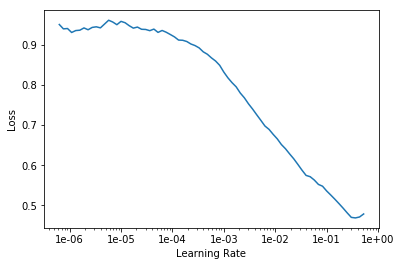

In [3]:
learn.lr_find()
learn.recorder.plot()

<b>fit</b>

fit(epochs:int, lr:Union[float, Collection[float], slice]=slice(None, 0.003, None), wd:Floats=None, callbacks:Collection[Callback]=None)

使用lr学习率使该模型适合该学习者，对于具有回调的时期的wd权重衰减。

如果传递多个学习率或权重衰减值，则使用判别层训练。 要控制训练行为，请使用回调系统或一个或多个预定义的回调。

In [4]:
learn.fit(1)

epoch,train_loss,valid_loss,accuracy,time
0,0.140004,0.090356,0.969087,01:08


<b>fit_one_cycle</b>

fit_one_cycle(learn:Learner, cyc_len:int, max_lr:Union[float, Collection[float], slice]=slice(None, 0.003, None), moms:Point=(0.95, 0.85), div_factor:float=25.0, pct_start:float=0.3, final_div:float=None, wd:float=None, callbacks:Optional[Collection[Callback]]=None, tot_epochs:int=None, start_epoch:int=None)

按照`1cycle policy`拟合模型。

使用周期长度`cyc_len`，每周期最大学习速率`max_lr`， momentum `moms`，分割因子`div_factor`，权重衰减`wd`和可选回调`callbacks`。使用OneCycleScheduler回调。

In [5]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,accuracy,time
0,0.081616,0.069781,0.978410,01:06


### See results
<b>predict</b>

predict(item:ItemBase, return_x:bool=False, batch_first:bool=True, with_dropout:bool=False, **kwargs)

返回项目的预测类别，标签和概率。

预测可用于从受过训练的learner获得您感兴趣的一个特定数据的单一预测。

In [6]:
learn.data.train_ds[0]

(Image (3, 28, 28), Category 3)

数据集的每个元素都是一个元组，其中第一个元素是数据本身，而第二个元素是目标标签。 因此，要获取数据，我们需要再次索引。

In [7]:
data = learn.data.train_ds[0][0]
data

In [8]:
pred = learn.predict(data)
pred

(Category 3, tensor(0), tensor([0.9981, 0.0019]))

元组的前两个元素分别是预测的类和标签。 这里的Label本质上是每个类的内部表示，因为类名是一个字符串，不能用于计算。 要检查每个标签对应的内容，请运行：

In [9]:
learn.data.classes

['3', '7']

所以类别'0'是3而类别'1'是7。

In [10]:
probs = pred[2]
probs

tensor([0.9981, 0.0019])

元组中的最后一个元素是预测的概率。 对于分类数据集，返回的概率数与类的数量相同; probs [i]是项目属于learn.data.classes [i]的概率。

In [11]:
learn.data.valid_ds[0][0]

<b>get_preds</b>

get_preds(ds_type:DatasetType=<DatasetType.Valid: 2>, with_loss:bool=False, n_batch:Optional[int]=None, pbar:Union[MasterBar, ProgressBar, NoneType]=None) → List[Tensor]

返回ds_type数据集上的预测和目标。

它将使用学习者对ds_type数据集中的所有数据进行推理，并返回预测; 如果未指定n_batch，它将在默认批量大小上运行预测。 如果with_loss，它还将返回每个预测的损失。

以下是检查默认批量大小的方法。

In [12]:
learn.data.batch_size

64

In [13]:
[i for i in DatasetType]

[<DatasetType.Train: 1>,
 <DatasetType.Valid: 2>,
 <DatasetType.Test: 3>,
 <DatasetType.Single: 4>,
 <DatasetType.Fix: 5>]

In [14]:
preds = learn.get_preds()
preds

[tensor([[9.9997e-01, 2.5585e-05],
         [9.9999e-01, 7.8341e-06],
         [9.9270e-01, 7.3038e-03],
         ...,
         [1.0696e-04, 9.9989e-01],
         [1.8108e-03, 9.9819e-01],
         [5.6496e-04, 9.9944e-01]]), tensor([0, 0, 0,  ..., 1, 1, 1])]

元组的第一个元素是包含所有预测的张量。

In [15]:
preds[0]

tensor([[9.9997e-01, 2.5585e-05],
        [9.9999e-01, 7.8341e-06],
        [9.9270e-01, 7.3038e-03],
        ...,
        [1.0696e-04, 9.9989e-01],
        [1.8108e-03, 9.9819e-01],
        [5.6496e-04, 9.9944e-01]])

而元组的第二个元素是包含所有目标标签的张量。

In [16]:
preds[1]

tensor([0, 0, 0,  ..., 1, 1, 1])

由于get_preds可以预测ds_type数据集中的所有数据，因此预测数量将等于验证数据集中的数据数量。

In [17]:
len(learn.data.valid_ds)

2038

In [18]:
len(preds[0]), len(preds[1])

(2038, 2038)

要获得整个训练数据集的预测，只需相应地设置ds_type参数即可。

In [19]:
learn.get_preds(ds_type=DatasetType.Train)

[tensor([[9.9815e-01, 1.8535e-03],
         [4.5293e-03, 9.9547e-01],
         [1.3613e-02, 9.8639e-01],
         ...,
         [9.9992e-01, 8.3174e-05],
         [9.8951e-01, 1.0486e-02],
         [7.0895e-04, 9.9929e-01]]), tensor([0, 1, 1,  ..., 0, 0, 1])]

要同时获得预测损失以及预测和目标，请在参数中设置with_loss = True。

In [20]:
learn.get_preds(with_loss=True)

[tensor([[9.9997e-01, 2.5585e-05],
         [9.9999e-01, 7.8341e-06],
         [9.9270e-01, 7.3038e-03],
         ...,
         [1.0696e-04, 9.9989e-01],
         [1.8108e-03, 9.9819e-01],
         [5.6496e-04, 9.9944e-01]]),
 tensor([0, 0, 0,  ..., 1, 1, 1]),
 tensor([2.5749e-05, 7.6294e-06, 7.3307e-03,  ..., 1.0681e-04, 1.8125e-03,
         5.6505e-04])]

<b>validate</b>

validate(dl=None, callbacks=None, metrics=None)

使用潜在的回调和指标在`dl`上进行验证。

在给定的DataLoader `dl`上返回计算的`loss`和当前模型`metrics`。默认`dl`是验证data loader。

您可以使用以下方法检查学习者的默认指标：

In [24]:
str(learn.metrics)

'[<function accuracy at 0x000001A54C0A2048>]'

In [25]:
learn.validate()

[0.069781065, tensor(0.9784)]

In [26]:
learn.validate(learn.data.valid_dl)

[0.069781065, tensor(0.9784)]

In [28]:
learn.validate(learn.data.train_dl)

[0.040280234, tensor(0.9865)]

<b>show_results</b>

show_results(ds_type=<DatasetType.Valid: 2>, rows:int=5, **kwargs)

在ds_type数据集上显示预测结果。

请注意，顶部的文本编号是基础事实，或目标标签，中间的文本编号是预测，而底部的图像编号是图像数据本身。

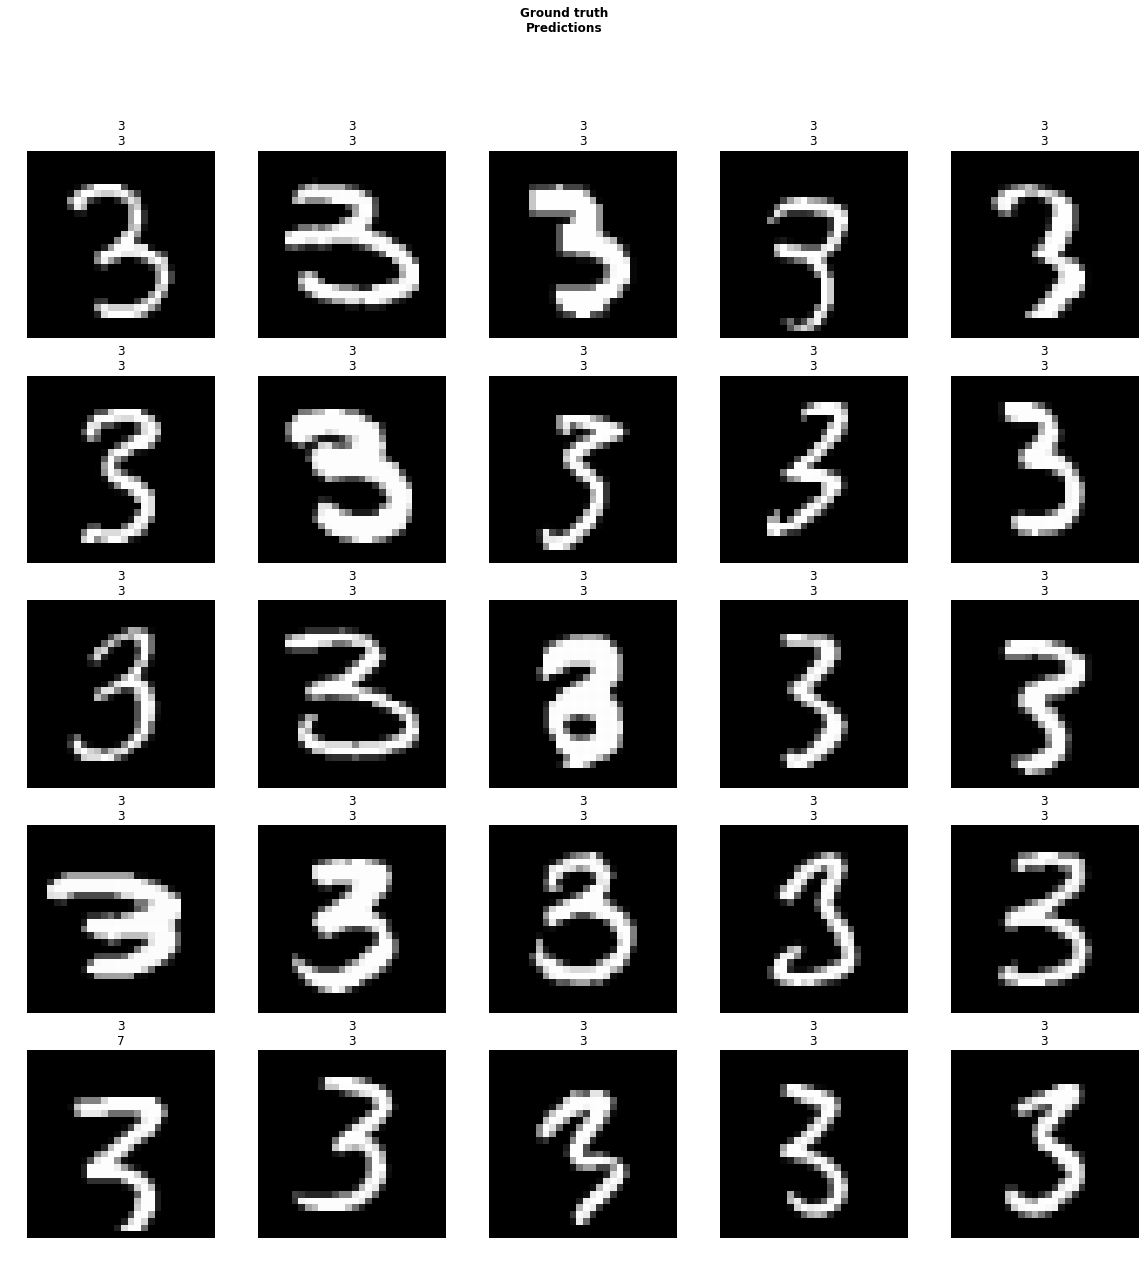

In [23]:
learn.show_results()

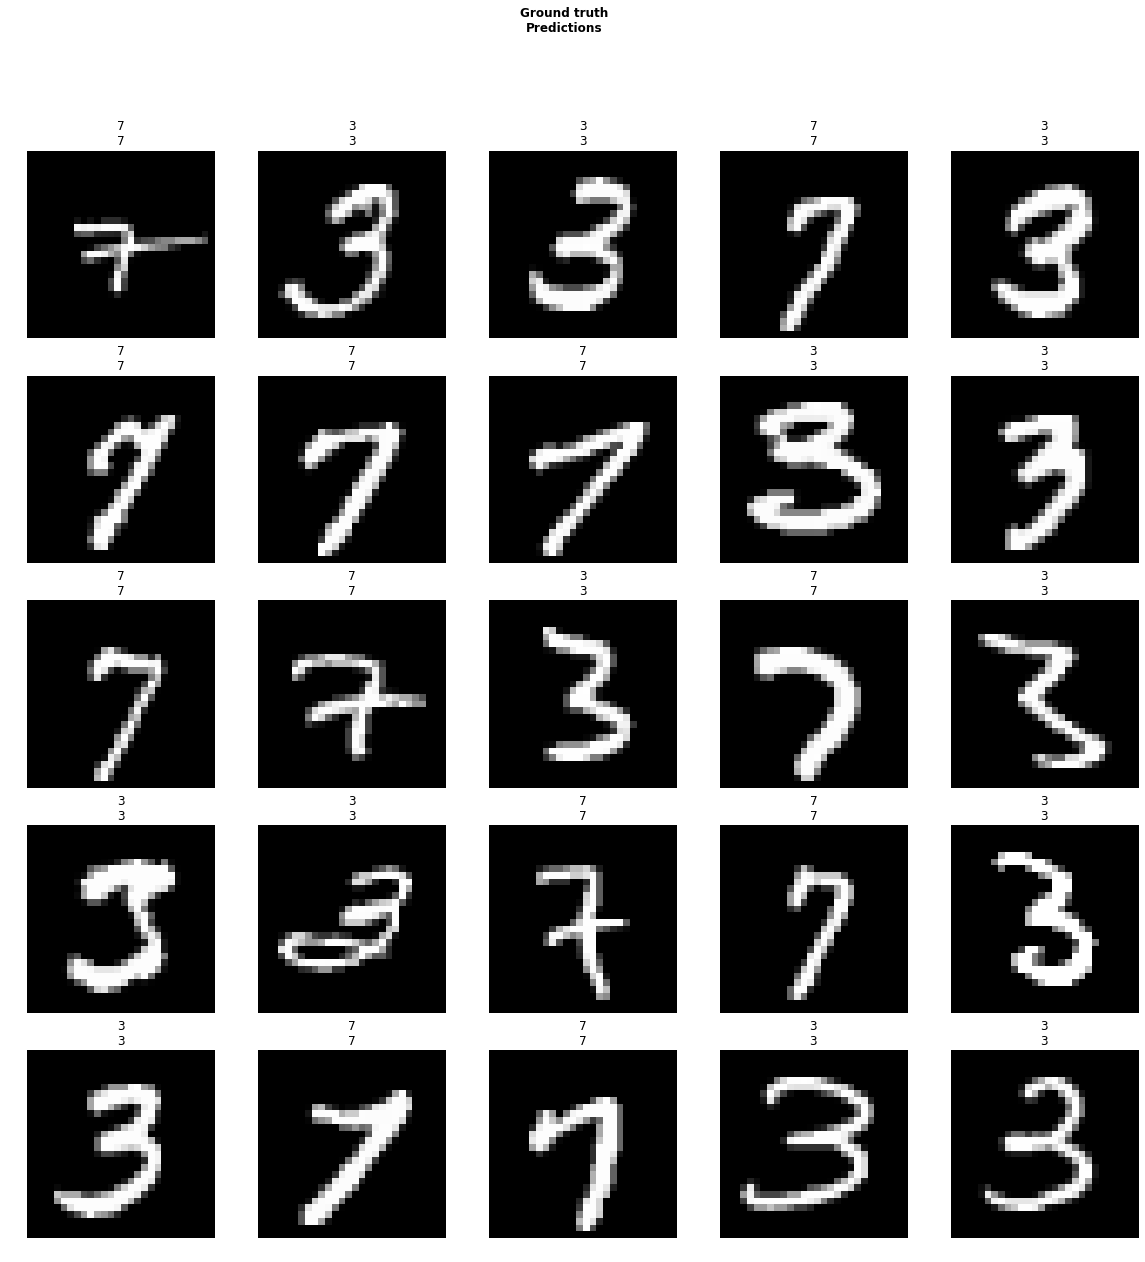

In [29]:
learn.show_results(ds_type=DatasetType.Train)

<b>pred_batch</b>

pred_batch(ds_type:DatasetType=<DatasetType.Valid: 2>, batch:Tuple=None, reconstruct:bool=False, with_dropout:bool=False) → List[Tensor]

从ds_type数据集返回一个batch的模型输出。

请注意，给定的预测数量等于batch大小。

In [30]:
learn.data.batch_size

64

In [31]:
preds = learn.pred_batch()
len(preds)

64

In [32]:
preds[:5]

tensor([[9.9997e-01, 2.5585e-05],
        [9.9999e-01, 7.8341e-06],
        [9.9270e-01, 7.3038e-03],
        [9.9970e-01, 3.0247e-04],
        [9.0999e-01, 9.0014e-02]])

In [33]:
item = learn.data.train_ds[0][0]
item

In [34]:
batch = learn.data.one_item(item)
batch

(tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],
 
          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],
 
          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]]], device='cuda:0'),
 tensor([0], device='cuda:0'))

In [39]:
learn.pred_batch(batch=batch)

tensor([[0.9981, 0.0019]])

<b>interpret</b>

interpret(learn:Learner, ds_type:DatasetType=<DatasetType.Valid: 2>, tta=False)

使用tta在ds_type上从学习者创建ClassificationInterpretation对象。

### Model summary

<b>model_summary</b>

model_summary(m:Learner, n:int=70)

使用`n`个字符的输出文本宽度打印`m`的摘要

In [42]:
model_summary(learn)

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 14, 14]         9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 14, 14]         128        True      
______________________________________________________________________
ReLU                 [64, 14, 14]         0          False     
______________________________________________________________________
MaxPool2d            [64, 7, 7]           0          False     
______________________________________________________________________
Conv2d               [64, 7, 7]           36,864     False     
______________________________________________________________________
BatchNorm2d          [64, 7, 7]           128        True      
______________________________________________________________________
ReLU                 [64, 7, 7]           0          False     
______________________________________________________________

### Test time augmentation

<b>TTA</b>

TTA(learn:Learner, beta:float=0.4, scale:float=1.35, ds_type:DatasetType=<DatasetType.Valid: 2>, with_loss:bool=False) → Tensors

应用TTA预测ds_type数据集。

应用测试时间增强以了解数据集ds_type。 我们将我们的常规预测（具有权重β）的平均值与通过训练集的增强版本（具有权重1-β）获得的预测的平均值进行比较。 为训练集决定的变换应用了一些变化比例控制缩放比例（这不是随机的），裁剪不是随机的，但我们确保获得图像的四个角。 翻转不是随机的，而是在每个角落图像上应用一次（因此总共有8个增强版本）。

### Gradient clipping

<b>clip_grad</b>

clip_grad(learn:Learner, clip:float=0.1) → Learner

在训练期间添加剪辑的渐变剪辑。

### Mixed precision training

<b>to_fp16</b>

to_fp16(learn:Learner, loss_scale:float=None, max_noskip:int=1000, dynamic:bool=True, clip:float=None, flat_master:bool=False, max_scale:float=16777216) → Learner

学习FP16精度模式。

使用MixedPrecision回调以混合精度训练（即使用fp16进行前向和后向传递，使用fp32进行重量更新），使用所有NVIDIA建议来确保速度和准确性。

<b>to_fp32</b>

to_fp32(learn:Learner)

将学习回到FP32精度模式。

### Distributed training
如果您想使用分布式培训或torch.nn.DataParallel，这些将直接为您包装模型。

<b>to_distributed</b>

to_distributed(learn:Learner, cuda_id:int, cache_dir:PathOrStr='tmp')

使用cuda_id学习分布式培训。

<b>to_parallel</b>

to_parallel(learn:Learner)

训练时使用nn.DataParallel，完成后删除

### Discriminative layer training

在拟合模型时，您可以传递学习率列表（和/或权重衰减量），这将对每个图层组应用不同的比率（即self.layer_groups中每个模块的参数）。 
在与您调用`split`的`Learner`一起工作时，您可以通过四种方式设置超参数：
1. param = [val1, val2 ..., valn] (n = number of layer groups)
2. param = val
3. param = slice(start,end)
4. param = slice(end)

如果我们选择将其设置为方式1，则必须指定一些与层组数量完全相等的值。 如果我们选择将其设置为方式2，则将对所有图层组重复所选值。 有关切片语法的说明，请参阅Learner.lr_range。

这是一个如何使用判别学习率的例子（请注意，在这种情况下你实际上不需要手动调用`Learner.split`，因为fastai使用这个确切的函数作为resnet18的默认拆分;这只是为了展示如何自定义它）：

In [43]:
# creates 3 layer groups
learn.split(lambda m: (m[0][6], m[1]))
# only randomly initialized head now trainable
learn.freeze()

In [44]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,accuracy,time
0,0.061244,0.057032,0.980864,01:20


In [49]:
# all layers now trainable
learn.unfreeze()
# optionally, separate LR and WD for each group
learn.fit_one_cycle(1, max_lr=(1e-4, 1e-3, 1e-2), wd=(1e-4,1e-4,1e-1))

epoch,train_loss,valid_loss,accuracy,time
0,0.020573,0.012853,0.996075,01:12


<b>lr_range</b>

lr_range(lr:Union[float, slice]) → ndarray

建立差异学习率从lr。

不是为每个组手动设置LR，而是使用Learner.lr_range通常更容易。 这是一种方便的方法，为每个图层组返回一个学习率。 如果你传递切片（开始，结束），那么第一组的学习率开始，最后一个是结束，其余的是几何均匀间隔的。

如果你只传递切片（结束），则最后一组的学习率结束，所有其他组的结束/ 10。 例如（对于有3层组的学习者）：

In [50]:
learn.lr_range(slice(1e-5,1e-3)), learn.lr_range(slice(1e-3))

(array([1.e-05, 1.e-04, 1.e-03]), array([0.0001, 0.0001, 0.001 ]))

<b>unfreeze</b>

unfreeze()

解冻整个模型。

将每个图层组设置为可训练（即requires_grad = True）。

<b>freeze</b>

freeze()

冻结到最后一个图层组。

将除最后一层之外的每个图层组设置为无法处理（即requires_grad = False）。

<b>freeze_to</b>

freeze_to(n:int)

将图层冻结到图层组n。

从上面我们知道什么是图层组，但是冻结在幕后做了什么呢？

freeze_to源代码可以理解为以下伪代码：

`
def freeze_to(self, n:int)->None:
    for g in self.layer_groups[:n]: freeze 
    for g in self.layer_groups[n:]: unfreeze
`

换句话说，例如，freeze_to（1）将冻结图层组0并解冻其余图层组，freeze_to（3）将冻结图层组0,1和2，但解冻其余图层组（如果有 剩下更多的图层组）。

冻结和解冻源都使用freeze_to定义：

* 当我们说冻结时，我们的意思是在指定的图层组中，所有具有权重（BatchNorm图层除外）的图层的requires_grad都设置为False，因此在训练期间不会更新图层权重。

* 当我们说解冻时，我们的意思是在指定的图层组中，所有具有权重（BatchNorm图层除外）的图层的requires_grad都设置为True，因此图层权重将在训练期间更新。

<b>split</b>

split(split_on:SplitFuncOrIdxList)

在split_on拆分模型。

一种基于split_model的结果设置layer_groups的便捷方法。 如果split_on是一个函数，它会调用该函数并将结果传递给split_model（例如，参见上文）。

## Saving and loading models
只需调用Learner.save和Learner.load即可保存和加载模型。 只保存参数，而不是实际的体系结构（因此在重新加载权重之前，您需要以相同的方式创建模型）。 模型保存到path / model_dir目录中。

<b>save</b>

save(file:PathLikeOrBinaryStream=None, return_path:bool=False, with_opt:bool=True)

将模型和优化程序状态（如果with_opt）与文件保存到self.model_dir。 文件可以是文件（文件或缓冲区）

如果agument name是一个绝对路径的pathlib对象，它将覆盖默认的基本目录（learn.path），否则模型将保存在相对于learn.path的文件中。

In [52]:
learn.save("trained_model")

In [54]:
learn.save("trained_model", return_path=True)

WindowsPath('C:/Users/Yang/.fastai/data/mnist_sample/models/trained_model.pth')

<b>load</b>

load(file:PathLikeOrBinaryStream=None, device:device=None, strict:bool=True, with_opt:bool=None, purge:bool=True, remove_module:bool=False)

使用device从self.model_dir加载模型和优化器状态（如果with_opt）。 文件可以是文件（文件或缓冲区）

此方法仅在保存后有效（不要与export / load_learner对混淆）。

如果purge参数为True（默认值），则内部调用purge并使用clear_opt = False来预先设置learn.opt。

In [55]:
learn = learn.load("trained_model")

## Deploying your model
当您准备好将模型投入生产时，请导出`Learner`的最小状态：

<b>export</b>

export(file:PathLikeOrBinaryStream='export.pkl', destroy=False)

在self.path /文件中导出`Learner`的状态。 文件可以是文件（文件或缓冲区）

如果agument fname是一个绝对路径的pathlib对象，它将覆盖默认的基本目录（learn.path），否则模型将保存在相对于learn.path的文件中。

传递destroy = True将摧毁学习者，释放大部分内存消耗。 有关具体信息，请参阅Learner.destroy。

此方法仅适用于其数据是通过数据块API创建的学习者。

否则，您必须自己在推理中创建一个学习者并使用Learner.load加载模型。

In [56]:
learn.export()

In [57]:
learn.export('trained_model.pkl')

In [58]:
path = learn.path
path

WindowsPath('C:/Users/Yang/.fastai/data/mnist_sample')

<b>load_learner</b>

load_learner(path:PathOrStr, file:PathLikeOrBinaryStream='export.pkl', test:ItemList=None, **db_kwargs)

将带有export_state的learner对象加载到带有空数据的path / file中，可选择在cpu上添加test和load。 文件可以是文件（文件或缓冲区）

此功能仅在导出后有效（不要与保存/加载对混淆）。

db_kwargs将传递给databunch的调用，因此您可以为测试集指定num_workers或bs。

In [60]:
learn = load_learner(path)

In [61]:
learn = load_learner(path, 'trained_model.pkl')

警告：如果在创建`Learner`时使用了任何自定义类，则必须首先在执行load_learner之前定义这些类。

## Freeing memory
如果您希望能够在不需要重新启动笔记本的情况下执行更多操作，则可以使用以下方法在不再需要时释放内存。

<b>purge</b>

purge(clear_opt:bool=True)

清除所有缓存属性的`Learner`以释放一些GPU内存。

如果learn.path是只读的，则可以将Learner中的model_dir属性设置为可写的完整libpath路径（通过设置learn.model_dir或在Learner构造函数中传递model_dir参数）。

<b>destroy</b>

destroy()

释放`Learner`内部，只留下一个不占用内存的空壳

如果需要释放Learner对象消耗的内存，请调用此方法。

它也可以通过其destroy = True参数通过Learner.export自动调用。

## Other methods
<b>init</b>

`init(init)`

使用函数init初始化所有权重（batchnorm除外），函数init通常来自PyTorch的nn.init模块。

<b>mixup</b>

`mixup(learn:Learner, alpha:float=0.4, stack_x:bool=False, stack_y:bool=True) → Learner`

添加mixup https://arxiv.org/abs/1710.09412

使用MixUpCallback。

<b>backward</b>

`backward(item)`

将项目传递给模型并计算渐变。 如果附加了backward_hooks，则很有用。

<b>create_opt</b>

`create_opt(lr:Floats, wd:Floats=0.0)`

使用lr学习率和wd权重衰减创建优化器。

您通常不需要自己调用它 - 它用于在拟合模型之前创建优化优化器。

<b>dl</b>

`dl(ds_type:DatasetType=<DatasetType.Valid: 2>)`

返回数据集类型data_type的数据加载器。

In [62]:
learn.dl()

DeviceDataLoader(dl=<torch.utils.data.dataloader.DataLoader object at 0x000001A59FC6BEB8>, device=device(type='cuda', index=0), tfms=[], collate_fn=<function data_collate at 0x000001A545FD6620>)

In [63]:
learn.dl(DatasetType.Train)

DeviceDataLoader(dl=<torch.utils.data.dataloader.DataLoader object at 0x000001A54D83F400>, device=device(type='cuda', index=0), tfms=[], collate_fn=<function data_collate at 0x000001A545FD6620>)

## class Recorder

`Recorder(learn:Learner, add_time:bool=True, silent:bool=False) :: LearnerCallback`

LearnerCallback，用于记录训练期间的epoch，丢失，选择和指标数据。

`Learner`自动创建一个Recorder对象 - 您不需要将其显式传递给callback_fns  - 因为其他回调依赖于它可用。 它存储每个批次的平滑损失，超参数值和度量，并为每个批次提供绘图方法。 请注意，Learner会自动设置一个属性，其中包含每个回调的蛇形名称，因此您可以通过Learner.recorder访问它，如下所示。

## Plotting methods

<b>plot</b>

`plot(skip_start:int=10, skip_end:int=5, suggestion:bool=False, return_fig:bool=None, **kwargs) → Optional[Figure]`

绘制学习率和损失，在skip_start和skip_end之间进行修剪。 可选择绘制并返回最小渐变

这主要与学习速率查找器一起使用，因为它显示了损失与学习速率的散点图。

In [67]:
path = untar_data(URLs.MNIST_SAMPLE)
data = ImageDataBunch.from_folder(path)
learn = cnn_learner(data, models.resnet18, metrics=accuracy)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.02E-03


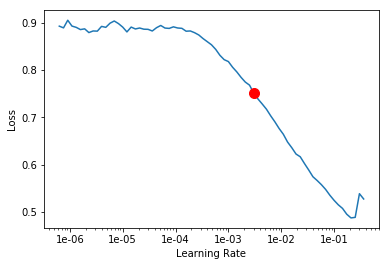

In [68]:
learn.lr_find()
learn.recorder.plot(suggestion = True)

<b>plot_losses</b>

`plot_losses(skip_start:int=0, skip_end:int=0, return_fig:bool=None) → Optional[Figure]`

绘制培训和验证损失。

请注意，验证损失仅在每个时期计算一次，而培训损失在每批后计算。

epoch,train_loss,valid_loss,accuracy,time
0,0.232938,0.143304,0.956330,01:10
1,0.115728,0.071970,0.975466,01:09
2,0.071941,0.058687,0.981845,01:09
3,0.043632,0.053750,0.983317,01:09
4,0.042715,0.051926,0.982826,01:09


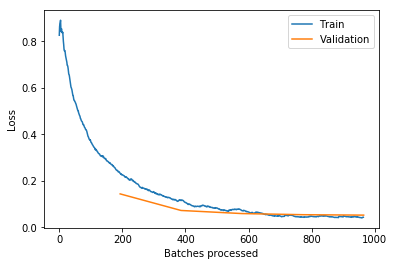

In [69]:
learn.fit_one_cycle(5)
learn.recorder.plot_losses()

<b>plot_lr</b>

`plot_lr(show_moms=False, skip_start:int=0, skip_end:int=0, return_fig:bool=None) → Optional[Figure]`

绘制学习率，show_moms包括动量。

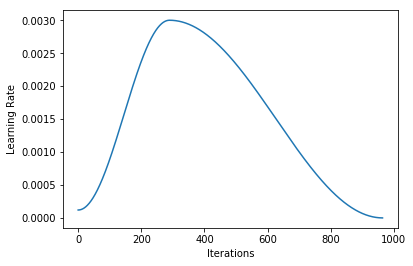

In [71]:
learn.recorder.plot_lr()

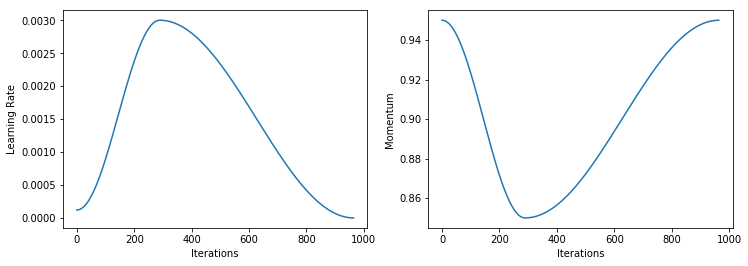

In [72]:
learn.recorder.plot_lr(show_moms=True)

<b>plot_metrics</b>

`plot_metrics(skip_start:int=0, skip_end:int=0, return_fig:bool=None) → Optional[Figure]`

绘制培训期间收集的指标。

请注意，度量标准仅在每个时期结束时收集，因此您需要至少训练两个时期才能在此处显示任何内容。

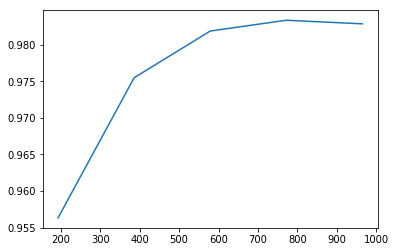

In [73]:
learn.recorder.plot_metrics()

## Callback methods

你不需要自己调用 - 他们会被fastai的Callback系统自动调用，以启用该类的功能。 有关更多详细信息，请参阅回调。

<b>on_backward_begin</b>

`on_backward_begin(smooth_loss:Tensor, **kwargs:Any)`

在任何其他回调有机会修改之前记录`loss`。

<b>on_batch_begin</b>

`n_batch_begin(train, **kwargs:Any)`

记录学习开始时的学习率和动力。

<b>on_epoch_end</b>

`on_epoch_end(epoch:int, num_batch:int, smooth_loss:Tensor, last_metrics=typing.Collection[typing.Union[torch.Tensor, numbers.Number]], **kwargs:Any) → bool`

保存`epoch`信息：num_batch，smooth_loss，metrics。

<b>on_train_begin</b>

`on_train_begin(pbar:PBar, metrics_names:StrList, **kwargs:Any)`

在训练开始时初始化录制状态。

## Inner functions
Recorder在此过程中使用以下函数，或者可以由其他回调调用。

<b>add_metric_names</b>

`add_metric_names(names)`

将名称添加到内部度量标准名称。

<b>format_stats</b>

`format_stats(stats:MetricsList)`

打印前格式化统计信息。

## Module functions
通常，您会想要使用`Learner`来训练您的模型，因为它们提供了许多功能并使事情变得更容易。 但是，为了获得最大的灵活性，您可以调用`Learner`在幕后调用的相同底层函数：

<b>fit</b>

`fit(epochs:int, learn:BasicLearner, callbacks:Optional[Collection[Callback]]=None, metrics:OptMetrics=None)`

使模型适合数据并使用loss_func和opt学习。

请注意，如果调用此函数，则必须自己创建优化程序，而Learn.fit会自动为您创建优化程序。

<b>train_epoch</b>

`train_epoch(model:Module, dl:DataLoader, opt:Optimizer, loss_func:LossFunction)`

使用optim opt和loss函数loss_func对dl的1个时期的模型进行简单训练。

你通常不需要自己调用 - 它适合每个epoch。

<b>validate</b>

`alidate(model:Module, dl:DataLoader, loss_func:OptLossFunc=None, cb_handler:Optional[CallbackHandler]=None, pbar:Union[MasterBar, ProgressBar, NoneType]=None, average=True, n_batch:Optional[int]=None) → Iterator[Tuple[IntOrTensor, Ellipsis]]`

在评估模式下计算dl上模型的loss_func。

这是适合每个epoch之后的调用。 如果要手动在DataLoader上运行推理，可以调用它。

<b>get_preds</b>

`get_preds(model:Module, dl:DataLoader, pbar:Union[MasterBar, ProgressBar, NoneType]=None, cb_handler:Optional[CallbackHandler]=None, activ:Module=None, loss_func:OptLossFunc=None, n_batch:Optional[int]=None) → List[Tensor]`

预测和目标的元组，以及使用dl，max批量n_batch的可选损失（如果loss_func）。

<b>loss_batch</b>

`loss_batch(model:Module, xb:Tensor, yb:Tensor, loss_func:OptLossFunc=None, opt:OptOptimizer=None, cb_handler:Optional[CallbackHandler]=None) → Tuple[Union[Tensor, int, float, str]]`

计算批次的损失和指标，根据需要调用回调。

您通常不需要自己调用它 - 它适合并验证每个批次的调用。 如果你设置选项，它只会向后传递。